In [1]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential

# Training MNIST data

Import the dataset and look at some examples.

The MNIST dataset consists of handwritten alphabets(both upper and lower A-Z)
Pixel values are from 0 to 255.

In [2]:
!pip install emnist
from emnist import extract_training_samples,extract_test_samples
x_train,y_train=extract_training_samples('letters')
x_test,y_test=extract_test_samples('letters')
set(y_train)
# note that these are just numpy arrays
type(x_train)

# train and test sets for digits 0-6
x_train = x_train[y_train < 6] / 255.
y_train = y_train[y_train < 6]
x_test = x_test[y_test < 6] / 255.
y_test = y_test[y_test < 6]


In [3]:
# the x training data is 60,000 examples of 28x28 images
print(x_train.shape)
print(y_train.shape)

(24000, 28, 28)
(24000,)


Look at some alphabets



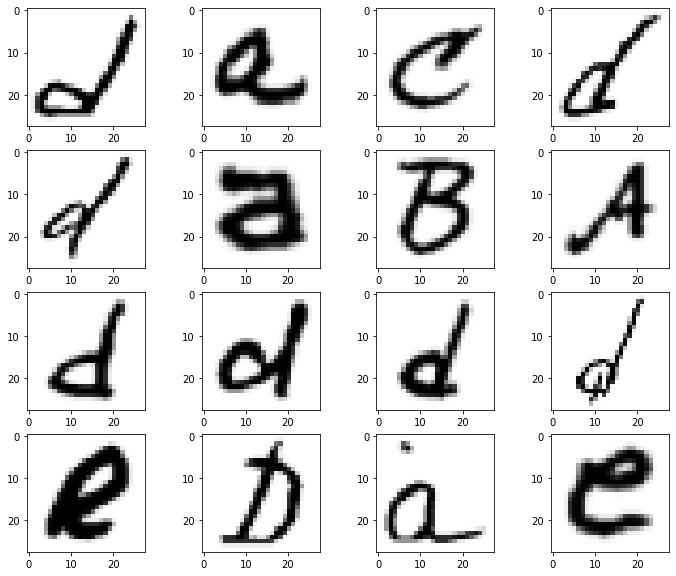

In [4]:
# Look at some random alphabets
X_shuffle = shuffle(x_train.copy(), random_state=42)

print('Look at some alphabets\n')
plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):
    plt.subplot(colums, row, i+1)
    plt.imshow(X_shuffle[i].reshape(28,28),interpolation='nearest', cmap='Greys')
plt.show()

## Data Preprocessing

We need to do the following to preprocess the data:

1. Divide the values by the max value (255)
2. Add a color channel (require by the convolutional layer)

By default Keras assumes images are formatted as (number of examples, x-dim, y-dim, number of colors)

An RGB image has 3 color channels, greyscale as 1 color channel

In [5]:
x_train.max()

1.0

In [6]:

# add the color channel
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

In [7]:
x_train.shape

(24000, 28, 28, 1)

## Setup the Model

This is a very basic convolutional network.
There are essentially two sections
1. convolutional feature extraction layers
2. dense (fully-connected) classifier layers

In [8]:
num_classes=6
filters=32
kernel_size=3
pool_size=2
dropout=0.2
input_shape = (28,28,1)

model = Sequential([
      # convolutional feature extraction
      # ConvNet 1

        # convoultional part
      keras.layers.Conv2D(filters, kernel_size, padding = 'valid',
              activation='relu',
              input_shape=input_shape),
        # pooling part
      keras.layers.MaxPooling2D(pool_size=pool_size),

      # ConvNet 2
      
        # convoultional part
      keras.layers.Conv2D(filters, kernel_size,
              padding = 'valid',
              activation='relu'),
        # pooling part
      keras.layers.MaxPooling2D(pool_size=pool_size),

      # classification 
      # will retrain from here
      keras.layers.Flatten(name='flatten'),

      keras.layers.Dropout(dropout),
      keras.layers.Dense(128, activation='relu'),
      
      keras.layers.Dropout(dropout, name='penult'),
      keras.layers.Dense(num_classes, activation='softmax', name='last')
  ])

In [9]:
# print summary of model as check
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

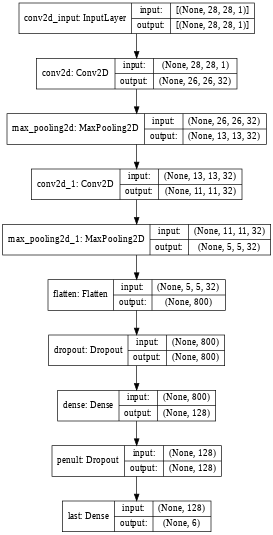

In [10]:
# print image of model as check
keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [11]:
es = keras.callbacks.EarlyStopping(min_delta=0.001, patience=2)

## Loss Functions

When y labels are sequential use `sparse_categorical_crossentropy`.  
When y labels are onehot encoded, use `categorical_crossentropy`.

In [12]:
model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_split=0.2,
                    batch_size=32,
                    epochs=1000,
                    callbacks=[es])

Epoch 1/1000
600/600 [==============================] - 5s 4ms/step - loss: 0.3161 - accuracy: 0.8857 - val_loss: 0.1469 - val_accuracy: 0.9498
Epoch 2/1000
600/600 [==============================] - 2s 4ms/step - loss: 0.1251 - accuracy: 0.9576 - val_loss: 0.0828 - val_accuracy: 0.9731
Epoch 3/1000
600/600 [==============================] - 2s 4ms/step - loss: 0.0900 - accuracy: 0.9705 - val_loss: 0.0702 - val_accuracy: 0.9773
Epoch 4/1000
600/600 [==============================] - 2s 3ms/step - loss: 0.0698 - accuracy: 0.9782 - val_loss: 0.0675 - val_accuracy: 0.9800
Epoch 5/1000
600/600 [==============================] - 2s 3ms/step - loss: 0.0591 - accuracy: 0.9811 - val_loss: 0.0593 - val_accuracy: 0.9833
Epoch 6/1000
600/600 [==============================] - 2s 4ms/step - loss: 0.0506 - accuracy: 0.9829 - val_loss: 0.0630 - val_accuracy: 0.9815
Epoch 7/1000
600/600 [==============================] - 2s 3ms/step - loss: 0.0474 - accuracy: 0.9856 - val_loss: 0.0551 - val_accuracy:

In [13]:
def plot_training_curves(history, title=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_accuracy'] + history.history['accuracy']),
                        max(history.history['val_accuracy'] + history.history['accuracy']))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['accuracy']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['accuracy'], label = 'accuracy')
    ax[1].plot(index, history.history['val_accuracy'], label = 'val_accuracy')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

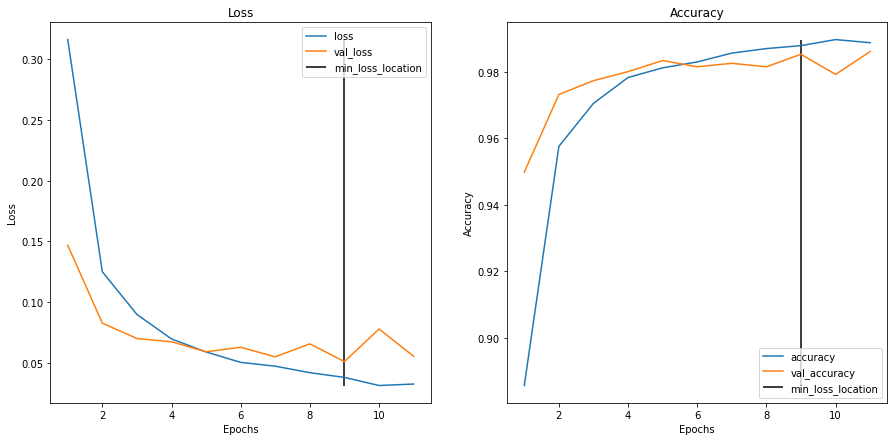

In [14]:
plot_training_curves(history)

In [15]:
# predict using the model
preds = model.predict(x_test)

In [16]:
x_test.shape

(4000, 28, 28, 1)

In [17]:
preds.shape

(4000, 6)

In [18]:
preds[0]

array([2.15632117e-08, 9.99793947e-01, 1.10030094e-04, 1.49845255e-06,
       2.57112588e-05, 6.88427244e-05], dtype=float32)

In [19]:
# classify the test set

# predict using the model
preds = model.predict(x_test)
# argmax along rows to get classification
preds = np.argmax(preds, axis=1).astype("uint8")

accuracy_score(y_test, preds)

0.984

In [20]:
preds.shape

(4000,)

# Transfer Learning Section

1. "Lock" the convolutional layers (set to non-trainable)
2. Remove original output layer, add new output layer with 5 neurons
3. Train classifier on my own new dataset (A,B,C,D,E)

## Preprocessing my image data (A,B,C,D,E)

In [21]:
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import glob

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


pillow (PIL) is the python package for working with real images:

[https://pillow.readthedocs.io/en/stable/index.html](https://pillow.readthedocs.io/en/stable/index.html)

I have some images of cats in google drive that I'll be using for example.
How to mount google drive in the colab env:
[https://www.kaggle.com/questions-and-answers/162449](https://www.kaggle.com/questions-and-answers/162449)

In [23]:
images_A = glob.glob('drive/MyDrive/Colab_Notebooks/ML2_HW4/alphabet_images/A/**/*.png',recursive=True)
images_B = glob.glob('drive/MyDrive/Colab_Notebooks/ML2_HW4/alphabet_images/B/**/*.png',recursive=True)
images_C = glob.glob('drive/MyDrive/Colab_Notebooks/ML2_HW4/alphabet_images/C/**/*.png',recursive=True)
images_D = glob.glob('drive/MyDrive/Colab_Notebooks/ML2_HW4/alphabet_images/D/**/*.png',recursive=True)
images_E = glob.glob('drive/MyDrive/Colab_Notebooks/ML2_HW4/alphabet_images/E/**/*.png',recursive=True)

images=images_A+images_B+images_C+images_D+images_E
len(images)

100

Open the image and resize it.
Note that the hand written images should be resized to (28,28).

[https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize)

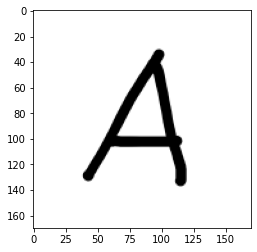

In [24]:
im = Image.open(images[0])
plt.imshow(im)

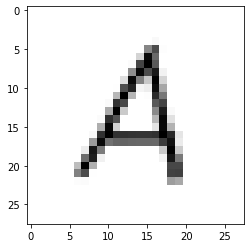

In [25]:
size = (28,28)
im = im.resize(size)
plt.imshow(im)


Convert the image to greyscale with "L" option.

[https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert)

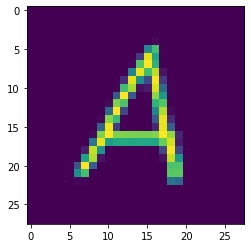

In [26]:
from PIL import Image
import PIL.ImageOps 

im = im.convert("L")
im=PIL.ImageOps.invert(im)
plt.imshow(im)

## Turning them into numpy array to be able to feed into neural network

In [27]:
im = np.array(im)
im

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 121, 179,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [28]:
im.max()

255

In [29]:
print(im.shape)

(28, 28)


## Resizing images to 28 x 28 and converting to grey scale

In [30]:
# load each image, run the initial conversion steps, combine in a list and invert
new_images = []
new_size = (28,28)
for im in images:
  im = Image.open(im).convert("L").resize(new_size)
  im = PIL.ImageOps.invert(im)
  new_images.append(np.array(im))
  

In [31]:
new_images[0].shape

(28, 28)

In [32]:
# "stack" the arrays
x = np.stack(new_images)
print(x.shape)

(100, 28, 28)


In [33]:
# as done in mnist add the color channel
x = x.reshape((100,28,28,1))
x.shape

(100, 28, 28, 1)

## Labeling the images

In [34]:
y=np.array([0]*20+[1]*20+[2]*20+[3]*20+[4]*20)
set(y)

{0, 1, 2, 3, 4}

In [35]:
# y=np.array([1]*20+[2]*20+[3]*20+[4]*20+[5]*20)
# set(y)

In [36]:
import numpy

indices = numpy.random.permutation(x.shape[0])
training_idx, test_idx = indices[:75], indices[75:] # Assigning 75% of the data in training 25% in tet
x_train_image, x_test_image = x[training_idx,:]/255, x[test_idx,:]/255
y_train_image, y_test_image = y[training_idx], y[test_idx]
y_train_image = y_train_image.astype(np.uint8)
y_test_image = y_test_image.astype(np.uint8)

In [37]:
y_test_image

array([1, 3, 1, 1, 1, 3, 1, 0, 2, 4, 2, 4, 1, 0, 4, 2, 2, 0, 2, 4, 3, 2,
       4, 1, 3], dtype=uint8)

In [38]:
# lock the ConvNet layers
layer_trainable = False
for layer in model.layers:
  layer.trainable = layer_trainable
  if layer.name == 'flatten':
    layer_trainable = True

print(f"{'Layer Name':17} {'Is Trainable?'}")
for layer in model.layers:
  print(f"{layer.name:17} {layer.trainable}")

Layer Name        Is Trainable?
conv2d            False
max_pooling2d     False
conv2d_1          False
max_pooling2d_1   False
flatten           False
dropout           True
dense             True
penult            True
last              True


In [39]:
from tensorflow.keras import Sequential, Model
# get the penultimate layer of the model
penult_layer = model.get_layer(name='penult')

# create a new output layer
output_layer = keras.layers.Dense(5, activation='softmax')(penult_layer.output)

# create new model with new output layer
new_model = Model(model.input, output_layer)

In [40]:
new_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

new_model_hist = new_model.fit(x_train_image, y_train_image,
                              validation_data=(x_test_image, y_test_image),
                              batch_size=10,
                              epochs=1000,
                              callbacks=[es])

Epoch 1/1000
8/8 [==============================] - 1s 31ms/step - loss: 2.0500 - accuracy: 0.3200 - val_loss: 1.3129 - val_accuracy: 0.5600
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.9559 - accuracy: 0.6000 - val_loss: 0.5681 - val_accuracy: 0.8000
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4251 - accuracy: 0.8667 - val_loss: 0.2766 - val_accuracy: 0.9200
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.1997 - accuracy: 0.9467 - val_loss: 0.1648 - val_accuracy: 0.9600
Epoch 5/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0904 - accuracy: 0.9867 - val_loss: 0.1228 - val_accuracy: 0.9600
Epoch 6/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0927 - accuracy: 0.9867 - val_loss: 0.0919 - val_accuracy: 1.0000
Epoch 7/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0631 - accuracy: 1.0000 - val_loss: 0.0801 - val_accuracy: 1.0000
Epoch 8/1000
8/8 [=

In [41]:
# classify the test set

# predict using the model
preds = new_model.predict(x_test_image)
# argmax along rows to get classification
preds = np.argmax(preds, axis=1).astype("uint8")

accuracy_score(y_test_image, preds)

1.0

## Final plot

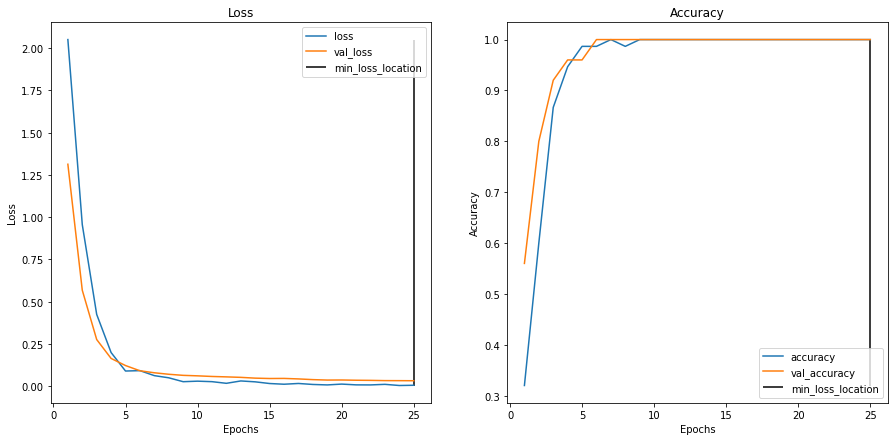

In [42]:
plot_training_curves(new_model_hist)